  -  [Metadata(Jena Climate Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(Jena Climate Dataset)] Property "https://schema.org/version" is recommended, but does not exist.


Epoch 1/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 0.0089 - val_loss: 6.8396e-04
Epoch 2/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 6.1104e-04 - val_loss: 6.5213e-04
Epoch 3/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 89s 11ms/step - loss: 5.9135e-04 - val_loss: 5.8892e-04
Epoch 4/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 5.7615e-04 - val_loss: 5.7484e-04
Epoch 5/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 5.6795e-04 - val_loss: 5.6869e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


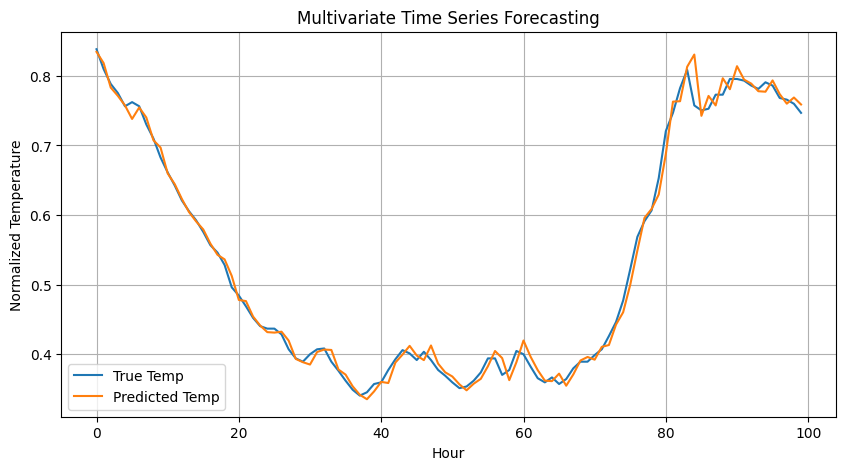

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download dataset from Kaggle using mlcroissant
try:
    import mlcroissant
except ImportError:
    %pip install mlcroissant

import mlcroissant as mlc

# Load dataset
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/mnassrib/jena-climate/croissant/download')
record_sets = croissant_dataset.metadata.record_sets
df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))

# Select multiple features using correct column names
features = df[
    [
        "jena_climate_2009_2016.csv/T+(degC)",
        "jena_climate_2009_2016.csv/p+(mbar)",
        "jena_climate_2009_2016.csv/rh+(%25)",
        "jena_climate_2009_2016.csv/wv+(m%2Fs)"
    ]
].astype(np.float32).values

# Normalize features
mean = features.mean(axis=0)
std = features.std(axis=0)
features = (features - mean) / std

# Create sequences
def create_multivariate_dataset(data, target_index=0, window=24):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, target_index])  # Predict temperature
    return np.array(X), np.array(y)

X, y = create_multivariate_dataset(features, target_index=0, window=24)

# Split dataset
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(24, X.shape[2])),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, validation_split=0.2)

# Predict and plot
preds = model.predict(X_test[:100]).flatten()
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='True Temp')
plt.plot(preds, label='Predicted Temp')
plt.title("Multivariate Time Series Forecasting")
plt.xlabel("Hour")
plt.ylabel("Normalized Temperature")
plt.legend()
plt.grid(True)
plt.show()
